# Goal

This code reconstructs a Gaussian Process ice-sheet emulator from its saved form. Necessary to run this code are: <br>
    1. GPflow, tensorflow, and pyDOE packages
    2. ice-sheet emulator tensorflow object
    3. the training data used to construct the model

### Setup

In [1]:
# import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pickle
# import the GPflow package to load the GP model and sample
import gpflow
# import tensorflow so we can restore the trained model
import tensorflow as tf

# Load the Model

### Load the Training Data

In [2]:
# define the path for the training data pickle
train_data_path="./d19_rcp_model_2100_traindata.pk1"
# load the training data from the pickle and print its keys
train_dat=pickle.load(open( train_data_path, "rb" ) )
train_dat.keys()

dict_keys(['kernel_code', 'Y_train', 'crevliq', 'X_train', 'time', 'clifvmax', 'model_name'])

### Restore the Trained GP model

In [3]:
# define the path for the emulator object and the kernel object
emulator_path='./d19_rcp_model_2100.ckpt'

In [4]:
# reconstruct the GP model
with gpflow.defer_build():
    
    # define the kernel
    k = eval(train_dat['kernel_code'])

    # create the model
    m = gpflow.models.GPR(train_dat['X_train'], \
        train_dat['Y_train'].reshape(np.size(train_dat['Y_train']),1), kern=k, name='rcp_model')
  
# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_graph = m.enquire_graph()
tf_session = m.enquire_session()
m.compile( tf_session )

# create the saver object and load the archived model object
saver = tf.train.Saver()
save_path = saver.restore(tf_session, emulator_path)
print("Model loaded from path: %s" % save_path)

# anchor the model to restore optimized hyperparameters
m.anchor(tf_session)

# fix the noise term (always done before sampling with the ice-sheet emulator)
m.likelihood.variance = 1e-06

INFO:tensorflow:Restoring parameters from ./models/d19_rcp_model_2100.ckpt
Model loaded from path: None


/home/dmg370/.local/lib/python3.5/site-packages/gpflow/logdensities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


In [5]:
# view the hyperparameters of the optimized model
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
rcp_model/likelihood/variance,Parameter,None,+ve,True,(),True,1e-06
rcp_model/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,3.32921606402632
rcp_model/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,1.2769492441672783
rcp_model/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,0.05208231649623494
rcp_model/kern/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,7.428180456507366


# Sample from Emulator

Note that the emulator is currently defined along CREVLIQ, CLIFVMAX, and time. All ISM training runs were zeroed out (zero net contributions to SLR) at the year 2000 for consistency with DeConto et al. (2019) and LocalizeSL (Kopp et al. 2017).

To sample from the emulator, we must construct grids of the locations we wish to sample at, as the emulator is technically defined over the infinite R^3 domain. But the training axes (CREVLIQ, CLIFVMAX, and time) were all normalized to between 0.0 and 1.0 before the emulator was trained, so samples should also be taken between 0 and 1.0 (samples outside these priors will be extrapolations rather than interpolations with the emulator, which are inherently faulty and not very useful... the emulator just reverts to the prior zero-mean structure in these regions).

Once we take our samples, the results can be plotted/examined along denormalized axes.

### View training axes

In [7]:
print(train_dat['crevliq'])
print(train_dat['clifvmax'])
print(train_dat['time'])

[  0  15  30  45  60  75  90 105 120 135 150 165 180 195]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1990.  2000.  2010.  2020.  2030.  2040.  2050.  2060.  2070.  2080.
  2090.  2100.]


### Create a sample grid

NOTE: The sampling grid must be constructed with a method **identical** to that of the training grid. I follow this procedure below.

In [93]:
# choose how many points you want along each axis in your sampling grid
nx,ny,nt=len(train_dat['clifvmax'])*2-1,len(train_dat['crevliq'])*2-1,len(train_dat['time'])*2-1
nx,ny,nt=14,14,11
# define a sampling grid for visualization of the emulator
sample_clifvmax=np.linspace(0,1,nx)
sample_crevliq=np.linspace(0,1,ny)
sample_time=np.linspace(0,1,nt)
# create the meshgrid for sampling (X_sample)
xx, yy, tt = np.meshgrid(sample_clifvmax,sample_crevliq,sample_time, indexing='ij')
X_sample=np.transpose([tt,yy,xx]).reshape(nx*ny*nt,3)

### View denormalized axes

In [94]:
# to go backward on the axes normaliztion, provide both the array to invert and the original max and min values
def denormalize(x,xorig_max,xorig_min):
    x_out=x*(xorig_max-xorig_min)+xorig_min
    return x_out

In [95]:
# denormalize the sample grid
denorm_clifvmax=denormalize(sample_clifvmax,np.max(train_dat['clifvmax']),np.min(train_dat['clifvmax']))
denorm_crevliq=denormalize(sample_crevliq,np.max(train_dat['crevliq']),np.min(train_dat['crevliq']))
denorm_time=denormalize(sample_time,np.max(train_dat['time']),np.min(train_dat['time']))

In [96]:
print(denorm_crevliq)
print(denorm_clifvmax)
print(denorm_time)

[   0.   15.   30.   45.   60.   75.   90.  105.  120.  135.  150.  165.
  180.  195.]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.]
[ 1990.  2001.  2012.  2023.  2034.  2045.  2056.  2067.  2078.  2089.
  2100.]


## Sample the mean and variance at a time point

In [98]:
# get model outputs along grid using the GPflow object
# NOTE: THIS IS A COMPUTATIONAL EXPENSIVE STEP!
gpr_mean,gpr_var=m.predict_y(X_sample)
# reshape from a raveled vector into the same shape as the sample points
sample_mean=gpr_mean.reshape(nt,ny,nx)
sample_var=gpr_var.reshape(nt,ny,nx)

In [103]:
sample_mean.shape

(11, 14, 14)

In [104]:
# find the mean and variance in 2100
ind2100=np.where(denorm_time==2100)
sample_mean_2100=np.squeeze(sample_mean[ind2100,:,:])
sample_var_2100=np.squeeze(sample_var[ind2100,:,:])
np.shape(sample_mean_2100)

(14, 14)

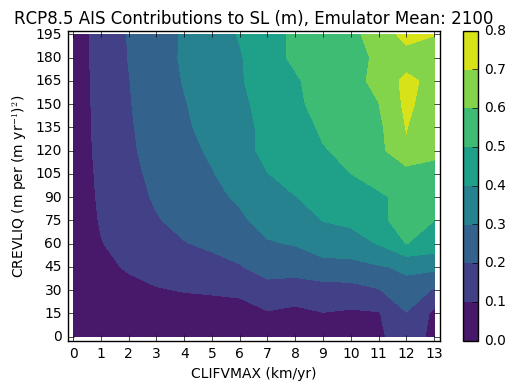

In [109]:
# plot the sample mean
plt.figure()
plt.set_cmap('viridis')
c1=plt.contourf(denorm_clifvmax,denorm_crevliq,sample_mean_2100)
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('RCP8.5 AIS Contributions to SL (m), Emulator Mean: 2100')
plt.colorbar(c1)
plt.show()

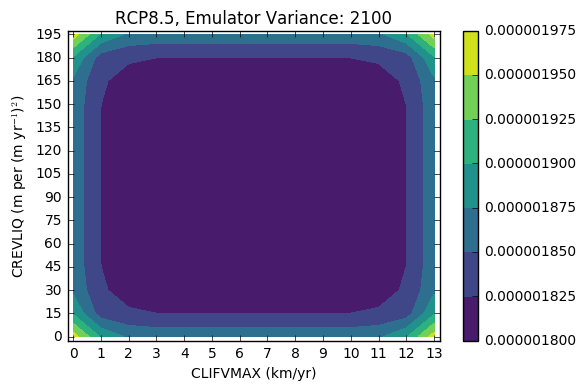

In [111]:
# plot the sample variance
plt.figure()
plt.set_cmap('viridis')
c1=plt.contourf(denorm_clifvmax,denorm_crevliq,sample_var_2100)
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('RCP8.5, Emulator Variance: 2100')
plt.colorbar(c1)
plt.show()

## Sample the mean and variance for a time series

In [136]:
# choose a crevliq/clifvmax location to sample at (note, this indexing may not always work depending on computational precision)
# (you could also just pick individual indices and then back out their C/C values)
clifvmax_sample_loc,crevliq_sample_loc=10,135
ind_clifvmax,ind_crevliq=np.where(denorm_clifvmax==clifvmax_sample_loc),np.where(denorm_crevliq==crevliq_sample_loc)
sample_mean_ts=np.squeeze(sample_mean[:,ind_crevliq,ind_clifvmax])
sample_var_ts=np.squeeze(sample_var[:,ind_crevliq,ind_clifvmax])

In [137]:
sample_mean_ts.shape

(11,)

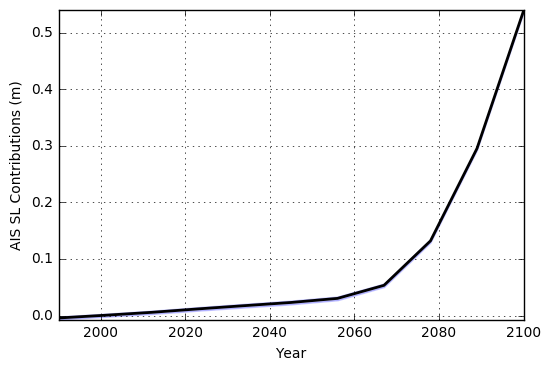

In [140]:
# plot the sample timeseries
plt.figure()
plt.plot(denorm_time,sample_mean_ts,c='k',lw=2)
plt.fill_between(denorm_time, \
                 sample_mean_ts - 2*np.sqrt(sample_var_ts), \
                 sample_mean_ts + 2*np.sqrt(sample_var_ts), \
                 color='b', alpha=0.2)
plt.axis('tight')
plt.ylabel('AIS SL Contributions (m)')
plt.xlabel('Year')
plt.grid()
plt.show()

## Sample individual timeseries

### Create a Latin-hypercube sample grid

In [179]:
# load the package to do LHC sampling
from pyDOE import lhs

# for reproducability, fix the random seed
np.random.seed(2)

# choose the number of parameters/dimensions
n=2
# choose how many samples we want
n_lhc_samples=1000
# develop a design to sample the space given the number of samples.
# Note that this is uniform following our emulators convention of being normalized to 1.0
lhd=lhs(n, samples=n_lhc_samples,criterion='maximin')

In [180]:
# create the sample grid with the LHC design (at each time point)
X_sample_lhd=np.empty((len(lhd)*len(sample_time),3),dtype='float')
for t in range(len(denorm_time)):
    
    # index in array creation
    t_first=t*len(lhd)
    t_last=t_first+len(lhd)
    
    # fill an array with out time period
    t_fill=np.empty(len(lhd))
    t_fill.fill(sample_time[t])
    
    # fill the sample grid array
    X_sample_lhd[t_first:t_last,:]=np.vstack((np.vstack((t_fill[:],lhd[:,0])),lhd[:,1])).T

### Draw Individual Timeseries Samples at each LHC point

This can take a long while to run, depending on how many sample points (LHC design + N timeseries) you choose.

In [181]:
# define how many timeseries samples you want
n_ts_samples=10
sample_ts_gp=np.squeeze(m.predict_f_samples(X_sample_lhd,n_ts_samples))
# reshape the array into individual timeseries
sample_ts_gp=sample_ts_gp.reshape(n_ts_samples,len(denorm_time),len(lhd))
samples_ts=np.empty((len(denorm_time),n_ts_samples*n_lhc_samples),dtype='float64')
for i in range(n_lhc_samples):
    for j in range(n_ts_samples):
        kind=i*n_ts_samples+j
        samples_ts[:,kind]=sample_ts_gp[j,:,i]

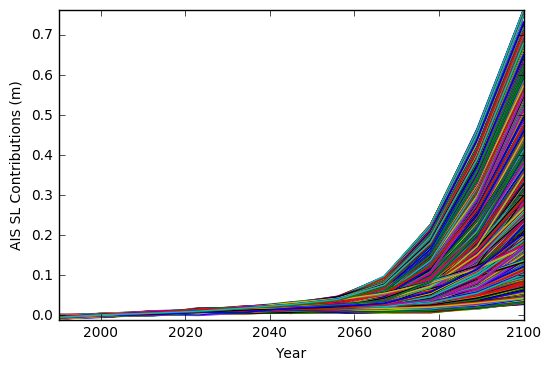

In [183]:
plt.figure()
plt.plot(denorm_time,samples_ts)
plt.axis('tight')
plt.ylabel('AIS SL Contributions (m)')
plt.xlabel('Year')
plt.show()